In [1]:
1+6

7

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
import gradio as gr
import gensim
import re
import nltk
from sklearn.model_selection import train_test_split
from tensorflow.nn import sigmoid
from nltk.corpus import stopwords
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Flatten, Dense, Bidirectional, GRU, Dense, Dropout, concatenate, LSTM
from tensorflow.keras.preprocessing.text import Tokenizer
nltk.download('stopwords')

ModuleNotFoundError: No module named 'matplotlib'

Importing a Word2Vec Arabic Model

In [ ]:
file_path = 'SG_300_3_400\w2v_SG_300_3_400_10.model'
word_embed = gensim.models.Word2Vec.load(file_path)

In [ ]:
word_embed.wv.most_similar('راءد')

[('وراءد', 0.6057729125022888),
 ('رايد', 0.5943275690078735),
 ('هيثم', 0.5192651748657227),
 ('عبدالاله', 0.5130357146263123),
 ('هاني', 0.5059362053871155),
 ('الصقري', 0.4963535964488983),
 ('ذيب', 0.4849216639995575),
 ('زياد', 0.4838601350784302),
 ('الحارثي', 0.4745340645313263),
 ('ساير', 0.47297826409339905)]

Importing and Preparing Data for Training

In [ ]:
df = pd.read_csv('CompanyReviews.csv')
df.head()

,Unnamed: 0,review_description,rating,company
0,0,رائع,1,talbat
1,1,برنامج رائع جدا يساعد على تلبيه الاحتياجات بشك...,1,talbat
2,2,التطبيق لا يغتح دائما بيعطيني لا يوجد اتصال با...,-1,talbat
3,3,لماذا لا يمكننا طلب من ماكدونالدز؟,-1,talbat
4,4,البرنامج بيظهر كل المطاعم و مغلقه مع انها بتكو...,-1,talbat


In [ ]:
df_c = df[['review_description', 'rating']]
df_c.dropna(inplace = True)

C:\Users\Nitro 5\AppData\Local\Temp\ipykernel_34076\2219360732.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_c.dropna(inplace = True)


In [ ]:
# Balancing Positive & Negative Comments

df_c = pd.concat(
    [
        df_c[(df_c.rating == -1)],
        #df_c[(df_c.rating == 0)],
        df_c[(df_c.rating == 1)].iloc[:(df_c.rating == -1).sum()],
    ]
)

array([[<Axes: title={'center': 'rating'}>]], dtype=object)

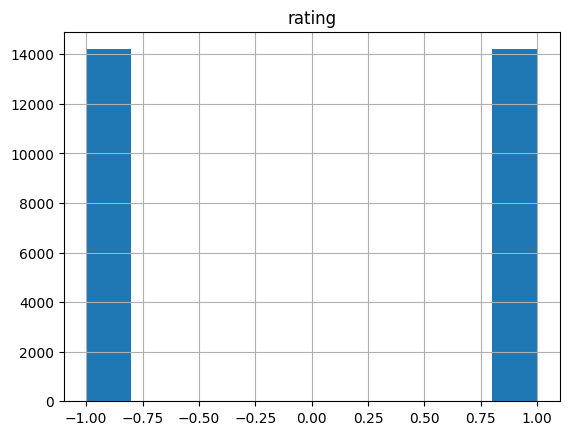

In [ ]:
df_c.hist()

Adjusting Stopwords to Better Fit in Our Data

In [ ]:

ar_s = stopwords.words('arabic')
ar_s = list(set(ar_s))
ar_sw = []

for word in ar_s:
  misspelled = re.sub('[أإآاًاً]', "ا", word)
  ar_sw.append(word)
  ar_sw.append(misspelled)

# adding extra words:
extra_words = ["بتكون", "بيكون", "اكتر", "أكتر", "آني", "وآني", "واني", "اللي", "ال", "له", "لي", "وانا"]
common_names = ['الفراش الأبيض White Bedding', 'سبرنك', 'السبرنك', 'عراقيه', 'عراقي', 'تركي', 'تركيه', 'دوشك', 'فراش', 'قياس', 'بيش', 'ابيش', 'شكد', 'اشكد', 'التوصيل', 'توصيل']
ar_sw.extend(extra_words)
ar_sw.extend(common_names)
ar_sw = list(set(ar_sw))
ar_sw.remove("لا")

print (len(ar_s), len(ar_sw), sep = '\n') # ar_sw will be used

701
869


In [ ]:
emojis = {
    "🙂": "يبتسم",
    "😂": "يضحك",
    "💔": "قلب حزين",
    "🙂": "يبتسم",
    "❤️": "حب",
    "❤": "حب",
    "😍": "حب",
    "😭": "يبكي",
    "😢": "حزن",
    "😔": "حزن",
    "♥": "حب",
    "💜": "حب",
    "😅": "يضحك",
    "🙁": "حزين",
    "💕": "حب",
    "💙": "حب",
    "😞": "حزين",
    "😊": "سعادة",
    "👏": "يصفق",
    "👌": "احسنت",
    "😴": "ينام",
    "😀": "يضحك",
    "😌": "حزين",
    "🌹": "وردة",
    "🙈": "حب",
    "😄": "يضحك",
    "😐": "محايد",
    "✌": "منتصر",
    "✨": "نجمه",
    "🤔": "تفكير",
    "😏": "يستهزء",
    "😒": "يستهزء",
    "🙄": "ملل",
    "😕": "عصبية",
    "😃": "يضحك",
    "🌸": "وردة",
    "😓": "حزن",
    "💞": "حب",
    "💗": "حب",
    "😑": "منزعج",
    "💭": "تفكير",
    "😎": "ثقة",
    "💛": "حب",
    "😩": "حزين",
    "💪": "عضلات",
    "👍": "موافق",
    "🙏🏻": "رجاء طلب",
    "😳": "مصدوم",
    "👏🏼": "تصفيق",
    "🎶": "موسيقي",
    "🌚": "صمت",
    "💚": "حب",
    "🙏": "رجاء طلب",
    "💘": "حب",
    "🍃": "سلام",
    "☺": "يضحك",
    "🐸": "ضفدع",
    "😶": "مصدوم",
    "✌️": "مرح",
    "✋🏻": "توقف",
    "😉": "غمزة",
    "🌷": "حب",
    "🙃": "مبتسم",
    "😫": "حزين",
    "😨": "مصدوم",
    "🎼 ": "موسيقي",
    "🍁": "مرح",
    "🍂": "مرح",
    "💟": "حب",
    "😪": "حزن",
    "😆": "يضحك",
    "😣": "استياء",
    "☺️": "حب",
    "😱": "كارثة",
    "😁": "يضحك",
    "😖": "استياء",
    "🏃🏼": "يجري",
    "😡": "غضب",
    "🚶": "يسير",
    "🤕": "مرض",
    "‼️": "تعجب",
    "🕊": "طائر",
    "👌🏻": "احسنت",
    "❣": "حب",
    "🙊": "مصدوم",
    "💃": "سعادة مرح",
    "💃🏼": "سعادة مرح",
    "😜": "مرح",
    "👊": "ضربة",
    "😟": "استياء",
    "💖": "حب",
    "😥": "حزن",
    "🎻": "موسيقي",
    "✒": "يكتب",
    "🚶🏻": "يسير",
    "💎": "الماظ",
    "😷": "وباء مرض",
    "☝": "واحد",
    "🚬": "تدخين",
    "💐": "ورد",
    "🌞": "شمس",
    "👆": "الاول",
    "⚠️": "تحذير",
    "🤗": "احتواء",
    "✖️": "غلط",
    "📍": "مكان",
    "👸": "ملكه",
    "👑": "تاج",
    "✔️": "صح",
    "💌": "قلب",
    "😲": "مندهش",
    "💦": "ماء",
    "🚫": "خطا",
    "👏🏻": "برافو",
    "🏊": "يسبح",
    "👍🏻": "تمام",
    "⭕️": "دائره كبيره",
    "🎷": "ساكسفون",
    "👋": "تلويح باليد",
    "✌🏼": "علامه النصر",
    "🌝": "مبتسم",
    "➿": "عقده مزدوجه",
    "💪🏼": "قوي",
    "📩":  "تواصل معي",
    "☕️": "قهوه",
    "😧": "قلق و صدمة",
    "🗨": "رسالة",
    "❗️": "تعجب",
    "🙆🏻": "اشاره موافقه",
    "👯": "اخوات",
    "©":  "رمز",
    "👵🏽": "سيده عجوزه",
    "🐣": "كتكوت",
    "🙌": "تشجيع",
    "👐🏽": "ايدي مفتوحه",
    "👌🏽": "بالظبط",
    "⁉️": "استنكار",
    "⚽️": "كوره",
    "🕶": "حب",
    "🎈": "بالون",
    "🎀":    "ورده",
    "💵":  "فلوس",
    "😋":  "جائع",
    "😛":  "يغيظ",
    "😠":  "غاضب",
    "✍🏻":  "يكتب",
    "🌾":  "ارز",    "❌": "رفض",
    "🍟": "طعام",
    "👬": "صداقة",
    "🐰": "ارنب",
    "☂": "مطر",
    "🐑": "خروف",
    "🗣": "صوت مرتفع",
    "👌🏼": "احسنت",
    "☘": "مرح",
    "😮": "صدمة",
    "😦": "قلق",
    "⭕": "الحق",
    "✏️": "قلم",
    "ℹ": "معلومات",
    "🙍🏻": "رفض",
    "⚪️": "نضارة نقاء",
    "🐤": "حزن",
    "💫": "مرح",
    "💝": "حب",
    "🍔": "طعام",
    "❤︎": "حب",
    "✈️": "سفر",
    "🍳": "ذكر",
    "🎤": "مايك",
    "🎾": "كره",
    "🐔": "دجاجة",
    "🙋": "سؤال",
    "📮": "بحر",
    "💉": "دواء",
    "🙏🏼": "رجاء طلب",
    "💂🏿 ": "حارس",
    "🎬": "سينما",
    "♦️": "مرح",
    "💡": "قكرة",
    "‼": "تعجب",
    "👼": "طفل",
    "🔑": "مفتاح",
    "♥️": "حب",
    "🕋": "كعبة",
    "🐓": "دجاجة",
    "💩": "معترض",
    "👽": "فضائي",
    "☔️": "مطر",
    "🍷": "عصير",
    "🌟": "نجمة",
    "☁️": "سحب",
    "👃": "معترض",
    "🌺": "مرح",
    "👊🏼": "ضرب",
    "🚶🏾‍♀️": "يسير",
    "👊": "ضربة",
    "😚": "حب",
    "🔸": "مرح",
    "👎🏻": "أكره",
    "👊🏽": "ضربة",
    "😙": "حب",
    "🎥": "تصوير",
    "👉": "جذب انتباه",
    "👏🏽": "يصفق",
    "💪🏻": "عضلات",
    "🏴": "اسود",
    "🔥": "حريق",
    "😬": "عدم الراحة",
    "👊🏿": "يضرب",
    "🌿": "ورقه شجره",
    "✋🏼": "تحية",
    "👐": "تحية",
    "☠️": "مرعب",
    "🎉": "يهنئ",
    "🔕": "صامت",
    "😿": "وجه حزين",
    "☹️": "وجه يائس",
    "😘": "حب",
    "😰": "خوف و حزن",
    "🌼": "ورده",
    "💋":  "بوسه",
    "👇": "لاسفل",
    "❣️": "حب",
    "🎧": "سماعات",
    "📝": "يكتب",
    "😇": "دايخ",
    "😈": "رعب",
    "🏃": "يجري",
    "✌🏻": "علامه النصر",
    "🔫": "يضرب",
    "❗️": "تعجب",
    "👎": "غير موافق",
    "🚶🏽": "يتمشي",
    "😯": "متفاجأ",
    "✊": "قوي",
    "😻": "اعجاب",
    "🙉": "قرد",
    "👧": "طفله صغيره",
    "💪🏽": "قوه",
    "💤": "ينام",
    "✍🏻": "يكتب",
    "❄️": "تلج",
    "💀": "رعب",
    "😤": "عابس",
    "☕️": "قهوه",
    "😹": "ضحك",
    "💓": "حب",
    "☄️ ": "نار",
    "👻": "رعب",
    "❎": "خطء",
    "🤮": "حزن",
}

In [ ]:
def preprocessing (text):

  '''
preprocessing levels:
1. demojizing: replacing emojis with their corresponding Arabic text
2. stopwords removal
3. applying other filteration ways using (re.sub). No need to clear punctuation since i have it already in: re.sub(r'[^/w/s]', '', text)
'''

  def demojize(text):
    for emoji, label in emojis.items():
      text = text.replace(emoji, ' ' + label + ' ')
    return text

  def remove_stop_words(text):
    text = " ".join([word for word in text.split() if word not in ar_sw])
    return text

  def extra_filtering(text):
    text = re.sub("سيئةة", "سيئه", text)
    text = re.sub(r"[ة]", "ه", text)
    text = re.sub(r'[^\w\s]', ' ', text) # removes everything except words and spaces
    text = re.sub('\d', '', text)
    text = re.sub('\s\w\s', ' ', text)
    text = re.sub(r"[أإآ]", "ا", text)
    text = re.sub(r"[ؤئ]", "ء", text)
    return text


  text = demojize(text)
  text = remove_stop_words(text)
  text = extra_filtering(text)
  text = remove_stop_words(text)

  return text

In [ ]:
# testing the function

texts = ['روعة', 'عة', 'فيله', 'اسكندنافية', 'برة', 'سيئة', 'تجربة جميلة', 'سيئةة']
ar_text = "مرحباً عزيزي. آني أحمد 🌹. حبيت أسأل عليك. !! ✨🔥😍 إن شالله تكون بخير..الله ."

edited = preprocessing(ar_text)
edited2 = [preprocessing(text) for text in texts]

print(
    edited, edited2, sep = '\n'
)
# this kind of preprocessing familiarizes our data with the word2vec model

مرحبا عزيزي احمد ورده حبيت اسال نجمه حريق حب شالله تكون بخير الله
['روعه', 'عه', 'فيله', 'اسكندنافيه', 'بره', 'سيءه', 'تجربه جميله', 'سيءه']


In [ ]:
# applying preprocessing to the data
df_c.review_description = df_c.review_description.apply(lambda x: preprocessing(x))

Vectorizing, Cleaning and Padding Data

In [ ]:
def costume_word2vec(text):
  word_to_seq = []
  for word in text.split():
    if word in word_embed.wv:
      w2vec = word_embed.wv[word]
    else: w2vec = np.zeros(300)

    word_to_seq.append(w2vec)

  return np.array(word_to_seq)


In [ ]:
def cleaning_empty_rows(comments, vectors):

  df_c.reset_index(drop = True, inplace = True)

  rows_to_drop = []

  for id, comment in enumerate(comments):
    if len(comment) == 0:
      rows_to_drop.append(id)

  rows_to_drop

  df_c.drop(rows_to_drop, inplace = True)
  df_c.reset_index(drop = True, inplace = True)

  rows_to_delete = []

  for i, vec in enumerate(vectors):

    if len(vec) == 0:
      rows_to_delete.append(i)

  df_c.drop(rows_to_delete, inplace = True)
  df_c.reset_index(drop = True, inplace = True)

  ensure_null_empty_comments = []
  for id, comment in enumerate(comments):
    if len(comment) == 0:
      ensure_null_empty_comments.append(id)

  ensure_null_empty_vectors = []
  for id, vec in enumerate(vectors):
    if len(vec) == 0:
      ensure_null_empty_vectors.append(id)

  if len(ensure_null_empty_comments) == 0 and len(ensure_null_empty_vectors) == 0:
    return ('the DataFrame is ready now for padding')


In [ ]:
def padding(sequence, maxlen = 25):

  '''
This function pads w2vec sequences with (,300)-shaped np array in each
row. the number of padded sequences should reach the max length
of 25 vectors per comment. Through padding and truncating, The final
shape will be (25, 300) for each row, where 25 represents the number
of max words per comment, and 500 represents the vector size of each word.
  '''

  word2vec_size = 300
  padding_vec = np.zeros(word2vec_size, dtype = 'float32')
  sequence_len = sequence.shape[0]

  while sequence_len < maxlen:
    sequence = np.vstack((sequence, padding_vec))
    sequence_len += 1

  if sequence.shape[0] != maxlen:       # truncating sequences exceeding the maxlen limit
    sequence = sequence[:maxlen, :]

  return sequence

In [ ]:
df_c['word2vec'] = df_c.review_description.apply(costume_word2vec)
cleaning_empty_rows(df_c.review_description, df_c.word2vec)
cleaning_empty_rows(df_c.review_description, df_c.word2vec)

'the DataFrame is ready now for padding'

In [ ]:
df_c['padded_seq'] = df_c.word2vec.apply(padding)

In [ ]:
df_c.head()

,review_description,rating,word2vec,padded_seq
0,التطبيق لا يغتح داءما بيعطيني لا يوجد اتصال با...,-1,"[[0.06687525659799576, 0.05879382789134979, 0....","[[0.06687525659799576, 0.05879382789134979, 0...."
1,لماذا لا يمكننا طلب ماكدونالدز,-1,"[[0.015342356, -0.02547007, 0.1518658, 0.12689...","[[0.015342356, -0.02547007, 0.1518658, 0.12689..."
2,البرنامج بيظهر المطاعم مغلقه انها فاتحه بقاله ...,-1,"[[-0.026470690965652466, 0.18882469832897186, ...","[[-0.026470690965652466, 0.18882469832897186, ..."
3,غالي جدا,-1,"[[0.11170384, -0.09435396, 0.16270615, -0.4193...","[[0.11170384, -0.09435396, 0.16270615, -0.4193..."
4,للاسف الواحد ينصدم زياده الاسعار للاسف المطاعم...,-1,"[[0.11759499460458755, -0.10764431208372116, 0...","[[0.11759499460458755, -0.10764431208372116, 0..."


In [ ]:
# converting positive rating from 1 to zero
y_axis = df_c.rating
y_axis = np.array(y_axis)
mask = (y_axis == 1)
y_axis[mask] *= 0

In [ ]:
# converting negative rating from -1 to 1
mask = (y_axis == -1)
y_axis[mask] *= -1
y_axis = pd.DataFrame(y_axis)

# The y, having values with only zeros and ones, is ready to be processed by sigmoid.

In [ ]:
df_c['y'] = y_axis

In [ ]:
df_c.iloc[:3]

,review_description,rating,word2vec,padded_seq,y
0,التطبيق لا يغتح داءما بيعطيني لا يوجد اتصال با...,-1,"[[0.06687525659799576, 0.05879382789134979, 0....","[[0.06687525659799576, 0.05879382789134979, 0....",1
1,لماذا لا يمكننا طلب ماكدونالدز,-1,"[[0.015342356, -0.02547007, 0.1518658, 0.12689...","[[0.015342356, -0.02547007, 0.1518658, 0.12689...",1
2,البرنامج بيظهر المطاعم مغلقه انها فاتحه بقاله ...,-1,"[[-0.026470690965652466, 0.18882469832897186, ...","[[-0.026470690965652466, 0.18882469832897186, ...",1


In [ ]:
df_c.iloc[15000:15003]

,review_description,rating,word2vec,padded_seq,y
15000,قمه الروعه والجمال شاءالله بتوفيق الله,1,"[[0.041224148, 0.16287784, -0.04612659, 0.0398...","[[0.041224148, 0.16287784, -0.04612659, 0.0398...",0
15001,حب حب,1,"[[0.25641853, -0.2344149, 0.09511715, -0.27733...","[[0.25641853, -0.2344149, 0.09511715, -0.27733...",0
15002,هواللهوالالهالحمد,1,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",0


Splitting Data

In [ ]:
X = df_c[['review_description', 'padded_seq']]
y = df_c.y

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
print(len(X_train), len(X_test), len(y_train), len(y_test), sep = '\n')

22368
5592
22368
5592


In [ ]:
def dataset_creater(x, y):
    x_tensor = tf.convert_to_tensor(x)  # Convert NumPy array to TensorFlow tensor
    y_tensor = tf.convert_to_tensor(y)  # Convert NumPy array to TensorFlow tensor

    data = tf.data.Dataset.from_tensor_slices((x_tensor, y_tensor))
    data = data.shuffle(1028).batch(32).prefetch(tf.data.AUTOTUNE)
    return data


x_numpy_train = np.array(X_train.padded_seq.tolist())
y_numpy_train = np.array(y_train.tolist())

x_numpy_test = np.array(X_test.padded_seq.tolist())
y_numpy_test = np.array(y_test.tolist())


train_dataset = dataset_creater(x_numpy_train, y_numpy_train)
test_dataset = dataset_creater(x_numpy_test, y_numpy_test)

In [ ]:
for x, y in train_dataset.take(1):
    print(x[0])
    print(y[0])

tf.Tensor(
[[ 0.12611327 -0.13138239  0.02334652 ...  0.3512145   0.00234702
  -0.11452236]
 [ 0.06226898  0.32325211 -0.16959733 ... -0.17186579 -0.01685726
   0.02974321]
 [-0.10335413 -0.05997237  0.29374197 ...  0.30673012 -0.14378722
  -0.04378572]
 ...
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]], shape=(25, 300), dtype=float64)
tf.Tensor(0, shape=(), dtype=int32)


Building and Training the Model ✨

In [ ]:
import tensorflow as tf

In [ ]:
model = Sequential([])

model.add(tf.keras.layers.Input(shape=(25, 300)))
model.add(tf.keras.layers.LSTM(32, return_sequences=True))
model.add(tf.keras.layers.Dropout(0.2))
model.add(tf.keras.layers.LSTM(64, return_sequences=True))
model.add(tf.keras.layers.Dropout(0.2))
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(1, activation='sigmoid'))

In [ ]:
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import AUC
from tensorflow.keras.callbacks import ModelCheckpoint

model.compile(optimizer=Adam(learning_rate=0.0001),
              loss=BinaryCrossentropy(),
              metrics=['accuracy', AUC(name='auc')])

In [ ]:
model.fit(train_dataset, validation_data = test_dataset, epochs=10)

Epoch 1/10
699/699 [==============================] - 157s 221ms/step - loss: 0.4269 - accuracy: 0.8033 - auc: 0.8864 - val_loss: 0.3439 - val_accuracy: 0.8501 - val_auc: 0.9260
Epoch 2/10
699/699 [==============================] - 145s 208ms/step - loss: 0.3388 - accuracy: 0.8574 - auc: 0.9284 - val_loss: 0.3286 - val_accuracy: 0.8603 - val_auc: 0.9334
Epoch 3/10
699/699 [==============================] - 145s 207ms/step - loss: 0.3252 - accuracy: 0.8637 - auc: 0.9341 - val_loss: 0.3192 - val_accuracy: 0.8655 - val_auc: 0.9366
Epoch 4/10
699/699 [==============================] - 151s 216ms/step - loss: 0.3184 - accuracy: 0.8655 - auc: 0.9370 - val_loss: 0.3149 - val_accuracy: 0.8677 - val_auc: 0.9386
Epoch 5/10
699/699 [==============================] - 152s 217ms/step - loss: 0.3113 - accuracy: 0.8690 - auc: 0.9398 - val_loss: 0.3113 - val_accuracy: 0.8705 - val_auc: 0.9398
Epoch 6/10
699/699 [==============================] - 147s 211ms/step - loss: 0.3057 - accuracy: 0.8711 - auc:

In [98]:
def predict_comment(text):

  common_name = 'الفراش الأبيض White Bedding' # common names are filtered out during preprocessing

  try:

    text = preprocessing(text)
    text = text.replace(common_name, ' ')
    text = costume_word2vec(text)
    text = padding(text)
    text = np.expand_dims(text, axis = 0)

    result = model.predict(text, verbose = 0)

    if result >= 0.64:
      return 'السلبية', result

    elif result <= 0.4:
      return 'الإيجابية', result

    else: return 'المحايدة', result

  except:
    return 'المحايدة', 0.5


In [99]:

def most_frequent(words, top_ = 5):
  from collections import Counter

  company_name = 'الفراش الأبيض White Bedding'

  words = str(words)
  words = re.sub(r'[^\w\s]', ' ', words)
  words = re.sub(company_name, ' ', words)
  
  filtered = [word for word in words.split() if word not in ar_sw]
  counted = Counter(filtered)
  most_freq = counted.most_common(top_) # provide five words starting from the most repeated ones

  text = ''
  for item in most_freq:
    text += item[0] + '، '

  return text[:-2]


Building Facebook Comments Extractor Using Native FB App GraphAPI

In [100]:
import facebook


def raw_data(post_id, pagination = False):

    import time

    my_token = 'EAADm2UqeccQBOy2YI3ElRQHI6CejvNRIfVn6tQOvyEe3zIqN25llSEhPbkMk8XZAt3oB1VsAmFZCGoPuvFGymA0SDHAhBaw9veIBgqIzeUrmlTXS034wTX2kgkTpaFN86GvZCUwFjker9H8c9XxgMQmmJAu2vR6qZBajt4tUuJABTn9m29wmxevr5eu1Xh1UpePZCizDQp8h0FTpQshFU4S3ZB'
    graph = facebook.GraphAPI(my_token)

    posts = graph.get_object(id=f"771186246558535_{post_id}",fields='comments') # scrapes for a single page

    comments_all = graph.get_all_connections(id =f'771186246558535_{post_id}', connection_name ='comments',
                                                fields ='comments'
    )
    time.sleep(3)

    return comments_all if pagination else posts



In [101]:

def extract_comments(post_id, limit = 500, include_replies = False, only_replies = False, pagination = False):

    '''
    This function extracts comments from facebook. Here you can decide the number of
    comments to fetch from a particular FB post. You can also decide what kind of comments you
    want to get: "include_replies" for example is designed to fetch people comments as well as
    page replies. The number of processed comments may exceed or slightly fall behind the limit
    according to the kind of comments you're fetching. 
    '''
    if pagination:
        r_com = raw_data(post_id, pagination = True)

        counter = 0
        raw_coms = []
        comments = []

        for com in r_com:
            raw_coms.append(com)
            counter += 1
            if counter == limit:
                break

        if include_replies:
                
                for raw_com in raw_coms:
                    if 'comments' in raw_com:
                        for comment in raw_com['comments']['data']:
                                comments.append(comment['message'])

        elif only_replies:

            for raw_com in raw_coms:
                if 'comments' in raw_com:
                    for comment in raw_com['comments']['data']:
                        if 'from' in comment:
                            comments.append(comment['message'])
            
        else:

            for raw_com in raw_coms:
                if 'comments' in raw_com:
                    for comment in raw_com['comments']['data']:
                        if 'from' not in comment:
                            comments.append(comment['message'])
        
        return comments

    else:
        comms = raw_data(post_id)
        return [comment['message'] for comment in comms['comments']['data']]

In [102]:
def read_comments(comments):
  import matplotlib.pyplot as plt

  frequent_words = most_frequent(comments)

  predicted_list = [predict_comment(comment) for comment in comments]
  sent_dict = {'الإيجابية': 0, 'السلبية': 0, 'المحايدة': 0}
  sent_text = ''


  sent_list = [sent[0] for sent in predicted_list]
  prob_list = [round(float(item[1]), 3) for item in predicted_list]

  positive_comments = [comments[ind] for ind, val in enumerate(sent_list) if val == 'الإيجابية']
  neutral_comments = [comments[ind] for ind, val in enumerate(sent_list) if val == 'المحايدة']
  negative_comments = [comments[ind] for ind, val in enumerate(sent_list) if val == 'السلبية']

  frequent_positive = most_frequent(positive_comments)
  frequent_negative = most_frequent(negative_comments)


  pos_neg = ( f'''
    الكلمات الأكثر تكراراً في التعليقات الإيجابية:
    {str(frequent_positive)},

    الكلمات الأكثر تكراراً في التعليقات السلبية:
    {str(frequent_negative)}
    '''
  )

  for sent in sent_list:
    sent_dict[sent] += 1

  for key, val in sent_dict.items():
    sent_text += key + ' : ' + str(val) + '\n'

  plt.pie(sent_dict.values(), labels = ['positive', 'negative', 'neutral'], autopct='%1.1f%%', startangle=140)
  plt.savefig('stats.png', dpi = 300, bbox_inches = 'tight')
  pie_fig = plt.imread('stats.png')

  most_positive_comment = comments[np.argmin(prob_list)]
  most_negative_comment = comments[np.argmax(prob_list)]

  if len(frequent_negative) != 0:
    pos_neg_com = (
    f'''
    تعليق إيجابي مميز:
    {most_positive_comment}

    أبرز تعليق سلبي:
    {most_negative_comment}

    '''
    )
    
  else: pos_neg_com = (
          f'''
    تعليق إيجابي مميز:
    {most_positive_comment}

    أبرز تعليق محايد:
    {most_negative_comment}

    '''
  )



  return (
      sent_text,
      pie_fig,
      pos_neg,
      pos_neg_com

  )


In [3]:
def comments_analyzer(post_id, pagination = False, limit = 500):
    if pagination:
        comments = extract_comments(str(post_id), pagination = True, limit = limit)
    else: comments = extract_comments(str(post_id))
    result = read_comments(comments)
    return result

In [104]:
'''
list of post IDs
to try the model, copy and paste one of these IDs inside gradio input:
616656483829022
606161281545209

'''

'\nlist of post IDs\nto try the model, copy and paste one of these IDs inside gradio input:\n2834368980031927\n616656483829022\n\n'

In [4]:
app_face = gr.Interface(comments_analyzer,
                        'number',
                        outputs = [
                            gr.Text(label = "لمحـة عامة"),
                            'image',
                            gr.Text(label = 'الكلمات الشائعة'),
                            gr.Text(label = 'أبرز التعليقات'),
                        ],
                        title = 'Customer Feedback Analyzer',
                        examples = [[616656483829022], [606161281545209]]
                        ).launch()

Running on local URL:  http://127.0.0.1:7860

To create a public link, set `share=True` in `launch()`.
